### A completar por el participante

In [1]:
punto_de_corte = 0.96
criterion = "gini" #“gini”, “entropy”, “log_loss”
max_depth = 100
min_samples_split = 15
min_samples_leaf = 5
max_features = 0.95
random_state = 6667

### Importamos los paquetes necesarios

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier

from IPython.display import Image  

from sklearn.metrics import confusion_matrix
from sklearn import tree

### Informacion adicional sobre las cervezas

In [3]:
directorio_data = '../data/'

In [5]:
dataset_completo_file = directorio_data + 'beer_reviews.csv'
df_extra_info_dataset = pd.read_csv(dataset_completo_file)[['beer_beerid', 'review_time', 'beer_abv']]

In [6]:
df_extra_info_dataset['review_date'] = pd.to_datetime(pd.to_datetime(df_extra_info_dataset['review_time'],unit='s')).dt.date
df_extra_info_dataset.head()

,beer_beerid,review_time,beer_abv,review_date
0,47986,1234817823,5.0,2009-02-16
1,48213,1235915097,6.2,2009-03-01
2,48215,1235916604,6.5,2009-03-01
3,47969,1234725145,5.0,2009-02-15
4,64883,1293735206,7.7,2010-12-30


In [7]:
df_extra_info_dataset_2 = df_extra_info_dataset.groupby(['beer_beerid', 'beer_abv']).agg(
    min_review_date = pd.NamedAgg(column='review_date', aggfunc='min'),
    max_review_date = pd.NamedAgg(column='review_date', aggfunc='max')
).reset_index()

df_extra_info_dataset_2['disponibilidad'] = (df_extra_info_dataset_2['max_review_date'] - df_extra_info_dataset_2['min_review_date']) / np.timedelta64(1, 'D')

df_extra_info_dataset_2.head()


,beer_beerid,beer_abv,min_review_date,max_review_date,disponibilidad
0,5,4.5,2001-07-08,2012-01-01,3829.0
1,6,5.6,2001-03-02,2012-01-02,3958.0
2,7,4.2,2001-10-19,2011-12-31,3725.0
3,8,4.2,2002-04-10,2011-06-29,3367.0
4,9,4.2,2002-03-15,2011-11-03,3520.0


## Feature engineering zone

In [23]:
#Esta funcion hace un join entre el dataframe enviado como parametro y el dataframe con informacion extra para obtener la disponibilidad, el max_review_date y el min_review_date
def feature_engineering_1(df):
    df_output = pd.merge(left=df, right=df_extra_info_dataset_2, left_on='beer_beerid', right_on='beer_beerid')
    return df_output

def feature_engineering_2(df):
    df_output = df.copy()
    df_output['review_promedio'] = (df['review_overall'] + df['review_aroma'] + df['review_appearance'] + df['review_palate'] + df['review_taste'])/5
    df_output['review_total'] = (df['review_overall'] + df['review_aroma'] + df['review_appearance'] + df['review_palate'] + df['review_taste'])
    return df_output

### Carga de datos

In [24]:
x_training_file = directorio_data + 'x_traininig.csv'
y_training_file = directorio_data + 'y_traininig.csv'

x_testing_file = directorio_data + 'x_testing.csv'
y_testing_file = directorio_data + 'y_testing.csv'

In [25]:
df_x_training_validacion = pd.read_csv(x_training_file)
df_y_training_validacion = pd.read_csv(y_training_file)

df_x_testing = pd.read_csv(x_testing_file)
df_y_testing = pd.read_csv(y_testing_file)

### Aplicamos las funciones de feature engineering a los datasets de training y testing

In [26]:
funciones = [
    "feature_engineering_1",
    "feature_engineering_2"
]

df_x_training_validacion_tmp = df_x_training_validacion.copy()
df_x_testing_tmp = df_x_testing.copy()

for funcion in funciones:
    df_x_training_validacion_tmp = locals()[funcion](df_x_training_validacion_tmp)
    df_x_testing_tmp = locals()[funcion](df_x_testing_tmp)

In [27]:
df_x_training_validacion_tmp.head()

,beer_beerid,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,min_review_date,max_review_date,disponibilidad,review_promedio,review_total
0,24856,2.500000,2.500000,2.500000,3.000000,2.500000,5.0,2005-07-19,2005-07-19,0.0,2.600000,13.000000
1,15994,4.500000,4.500000,4.000000,4.500000,4.500000,11.0,2004-02-18,2004-02-18,0.0,4.400000,22.000000
2,77086,4.000000,3.500000,4.000000,4.000000,3.500000,3.7,2012-01-05,2012-01-05,0.0,3.800000,19.000000
3,6810,3.642857,3.642857,4.071429,3.857143,3.785714,5.5,2002-10-23,2011-11-05,3300.0,3.800000,19.000000
4,18859,3.977778,3.700000,3.800000,3.988889,3.866667,6.5,2004-07-21,2011-07-28,2563.0,3.866667,19.333333


In [28]:
df_x_testing_tmp.head()

,beer_beerid,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,min_review_date,max_review_date,disponibilidad,review_promedio,review_total
0,22297,3.500000,3.500000,4.000000,3.500000,4.000000,5.0,2005-06-04,2005-06-04,0.0,3.700000,18.500000
1,4351,2.300000,2.450000,2.600000,2.400000,2.250000,10.6,2002-06-15,2011-10-15,3409.0,2.400000,12.000000
2,984,4.034014,3.710884,3.768707,3.911565,3.894558,6.2,2002-02-28,2011-08-08,3448.0,3.863946,19.319728
3,71053,2.571429,2.785714,3.285714,3.142857,2.642857,5.0,2011-07-15,2012-01-06,175.0,2.885714,14.428571
4,64413,4.000000,4.000000,3.750000,4.250000,3.750000,7.7,2010-12-14,2011-01-18,35.0,3.950000,19.750000


### Dejamos solo las columnas que queremos

In [29]:
columnas = [
    "review_overall",
    "review_aroma",
    "review_appearance",
    "review_palate",
    "review_taste",
    "beer_abv",
    "disponibilidad"
]

In [30]:
df_x_training_validacion_tmp = df_x_training_validacion_tmp[columnas]
df_x_testing_tmp = df_x_testing_tmp[columnas]

### Entrenamos el modelo

In [31]:
clf = DecisionTreeClassifier(
            criterion = criterion,
            max_depth = max_depth,
            min_samples_split = min_samples_split,
            min_samples_leaf = min_samples_leaf,
            max_features = max_features,
            random_state = random_state
        )
_ = clf.fit(df_x_training_validacion_tmp, df_y_training_validacion)

### Ejecutamos el modelo contra testing

In [19]:
y_validacion_pred = clf.predict_proba(df_x_testing_tmp)
df_y_validacion_pred_proba = pd.DataFrame(y_validacion_pred, columns = ['NO', 'SI'])
df_y_validacion_pred_proba['prediccion'] = 'SI'
df_y_validacion_pred_proba.loc[df_y_validacion_pred_proba['NO']>punto_de_corte, 'prediccion'] = 'NO'
df_y_validacion_pred_proba

,NO,SI,prediccion
0,1.000000,0.000000,NO
1,1.000000,0.000000,NO
2,1.000000,0.000000,NO
3,1.000000,0.000000,NO
4,1.000000,0.000000,NO
...,...,...,...
9795,1.000000,0.000000,NO
9796,1.000000,0.000000,NO
9797,1.000000,0.000000,NO
9798,0.785714,0.214286,SI


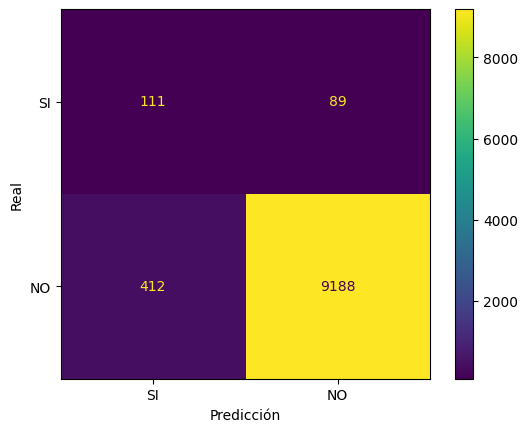

In [20]:
cm = confusion_matrix(df_y_testing, df_y_validacion_pred_proba['prediccion'], labels=['SI', 'NO'])
true_positives = cm[0,0]
true_negatives = cm[1,1]
false_positives = cm[1, 0]
false_negatives = cm[0,1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['SI', 'NO'])
disp.plot()
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [21]:
metrica_negocio = ((4000*true_positives) - (500*false_positives))/(true_positives + false_negatives)
metrica_negocio

1190.0